# <center>  🎵 Mood Detection from Text + Music Recommendation </center> 
This deep learning NLP project classifies the **emotional tone of a sentence** and suggests a **music playlist** based on detected mood. It uses **LSTM (TensorFlow/Keras)** for sequence modeling and **GloVe embeddings** for semantic understanding.

###  What this project does:
- Detects emotions like joy, sadness, anger, fear, surprise, love from text
- Recommends matching music playlists (using Spotify-style mapping)
- Built fully by me to learn **text classification, embeddings, and real-world NLP**

###  Why it matters:
In the real world, mood-aware systems can personalize experiences in chatbots, mental health apps, music players, etc.


##  Step 1: Load Emotion Dataset

In [57]:
from datasets import load_dataset

In [58]:
ds = load_dataset('emotion')

In [59]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [60]:
label_names = ds['train'].features['label'].names

##  Step 2: Text Cleaning

In [61]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuations
    text = re.sub(r'\s+', ' ', text).strip() #remove unwanted gaps
    return text


train_texts = [clean_text(t) for t in ds['train']['text']]
test_texts =  [clean_text(t) for t in ds['test']['text']]
val_texts =  [clean_text(t) for t in ds['validation']['text']]

In [62]:
train_texts[:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

##  Step 3: Tokenization + Sequences

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [64]:
tokenizer = Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(train_texts)  #This creates an internal dictionary like : {   'i': 1,   'am': 2,   'happy': 3 }

train_seq = tokenizer.texts_to_sequences(train_texts)  #Each word is replaced with its index from the vocabulary created earlier.
val_seq   = tokenizer.texts_to_sequences(val_texts)
test_seq  = tokenizer.texts_to_sequences(test_texts)

In [65]:
#vocab size 
vocab_size = len(tokenizer.word_index) + 1  #It calculates how many unique words your tokenizer has learned.

In [66]:
vocab_size

15214

##  Step 4: Padding Sequences

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [68]:
# to get the lenghts
seq_lengths = [len(seq) for seq in train_seq]

# Set maxlen as 90th percentile length
MAX_LEN = int(np.percentile(seq_lengths, 90))
print(MAX_LEN)

35


In [69]:
padded_train = pad_sequences( 
    train_seq,
    maxlen=MAX_LEN,
    padding='post' 
)

padded_val   = pad_sequences(val_seq, maxlen=MAX_LEN, padding='post')
padded_test  = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

In [70]:
padded_train.shape

(16000, 35)

In [71]:
train_labels = np.array(ds['train']['label'])
val_labels   = np.array(ds['validation']['label'])
test_labels  = np.array(ds['test']['label'])

- Why?
       
      Because:

      Labels, however, are often Python lists or Series and need to be converted to NumPy arrays for compatibility with model training.

      Keras models expect NumPy arrays (or tensors) during model.fit(), model.evaluate(), and model.predict().

      why not text then -because Text inputs are usually processed with Tokenizer → sequences → padded arrays (already NumPy-like).

## 🧠 Step 5: Build the Model (LSTM + Embeddings)

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense 

In [73]:
model = Sequential()

model.add(
    Embedding(
    input_dim=vocab_size,
    output_dim=128,
    input_length=MAX_LEN  #the max length we find and decided
    ))

model.add(LSTM(64))  # 64 is the number of units (or memory cells) in the LSTM layer

# model.add(Bidirectional(LSTM(64)))

# model.add(Dropout(0.5))  # NEW 
        
model.add(Dense(6, activation = 'softmax'))


Tried BiLSTM and regularization (dropout), but standard LSTM gave the best validation performance (89.9%).

- What happens with LSTM(64)?
        
            It reads the sequence step-by-step (word-by-word).

            It uses 64 memory slots to learn and remember important features.

            Output shape becomes: (batch_size, 64)

- Rule of Thumb
    
            UnitS   When to Use
            32	    For small datasets
            64	    Good balance — commonly used
            128+	For large datasets or deep models

In [74]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 128)           1947392   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1997190 (7.62 MB)
Trainable params: 1997190 (7.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 💡 Step: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 0.5715102157451064, 1: 0.49732686808404825, 2: 2.044989775051125, 3: 1.2351397251814111, 4: 1.3766993632765445, 5: 4.662004662004662}


In [76]:
history = model.fit(
    padded_train,
    train_labels,
    validation_data=(padded_val, val_labels),
    epochs=5,
    class_weight=class_weights  
)


Epoch 1/5
500/500 [==============================] - 13s 24ms/step - loss: 1.5669 - accuracy: 0.2733 - val_loss: 1.1118 - val_accuracy: 0.4580
Epoch 2/5
500/500 [==============================] - 6s 12ms/step - loss: 0.7763 - accuracy: 0.6844 - val_loss: 0.6323 - val_accuracy: 0.7865
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 0.3940 - accuracy: 0.8730 - val_loss: 0.3952 - val_accuracy: 0.8805
Epoch 4/5
500/500 [==============================] - 5s 10ms/step - loss: 0.2160 - accuracy: 0.9295 - val_loss: 0.3677 - val_accuracy: 0.8920
Epoch 5/5
500/500 [==============================] - 5s 10ms/step - loss: 0.1510 - accuracy: 0.9518 - val_loss: 0.3499 - val_accuracy: 0.8880


* * *
#### analysis and insights

- Train Accuracy → 95.8% ✅   

- Val Accuracy   → 89.% 9✅

- Gap ≈ 5.3% → Normal. No big overfitting ❌`  

#### Interpretation:

| Metric | Status | Notes |
| --- | --- | --- |
| Train Accuracy | ✅ High (good) | Means model learned well on training data |
| Validation Accuracy | ✅ High | Means it's generalizing well |
| Accuracy Gap | ✅ Acceptable | 5% gap is fine; >10% would need tuning |
| Loss Trend | ✅ Downward | No divergence = stable training |

✅ Overall — **your model is working well.**

* * *

##  Evaluation - Accuracy, Confusion Matrix, Class-wise Accuracy

In [77]:
# ✅ Step 8: Evaluate on test set
loss, accuracy = model.evaluate(padded_test, test_labels)
print(" Test Accuracy:", accuracy)


63/63 [==============================] - 0s 6ms/step - loss: 0.3435 - accuracy: 0.8845
 Test Accuracy: 0.8845000267028809


63/63 [==============================] - 0s 4ms/step


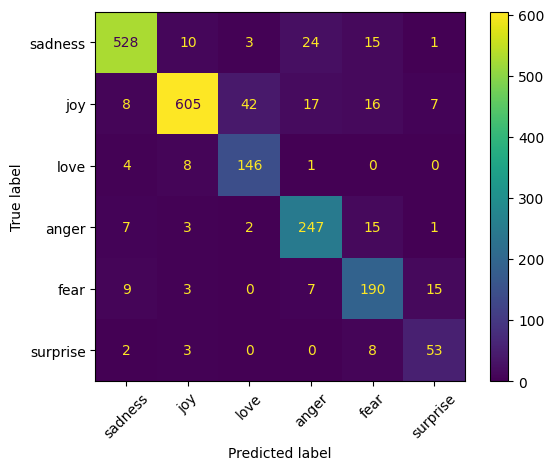

In [78]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# ✅ Step 9: Confusion Matrix
pred_probs = model.predict(padded_test)
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(test_labels, pred_labels)  #Experiment: Added class weighting using sklearn to improve minority class accuracy.

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45)
plt.show()


### 📈 Model Training Progress

Plot: Accuracy & Loss for LSTM with class weights

In [79]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


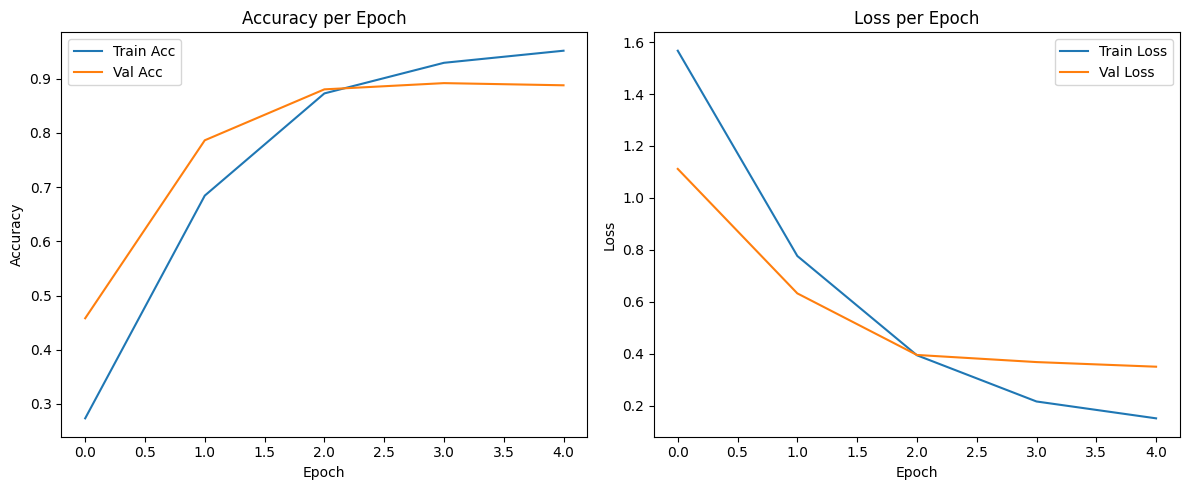

In [80]:
plot_history(history)

## Predict Mood for New Input

In [81]:
#  Emotion to Music Mapping
mood_to_music = {
    "joy": ["Happy Vibes 💃", "Sunshine Pop ☀️", "Feel Good Hits 🎶"],
    "sadness": ["Soothing Piano 🎹", "Rainy Day Acoustics 🌧️", "Sad Indie 🎧"],
    "love": ["Romantic Chill 💖", "Soft Love Songs 💌", "Heartbeats 🎼"],
    "anger": ["Heavy Metal ⚡", "Break the Silence 🔥", "Rap Battle Mode 🎤"],
    "fear": ["Ambient Calm 🌌", "Safe Space 🔐", "Gentle Focus 🧘"],
    "surprise": ["Eclectic Mix 🎲", "Unexpected Beats 🔀", "Feel the Twist 🤯"]
}


In [82]:
def predict_mood(text):
    # Clean and preprocess input
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    # Predict
    pred = model.predict(padded)[0]

    # Get top 2 predicted moods
    top_2 = pred.argsort()[-2:][::-1]
    results = [(label_names[i], round(pred[i]*100, 2)) for i in top_2]

    # Show result
    print(f"\nDetected Mood: {results[0][0]} ({results[0][1]}%)")
    print("Other Possible Mood:", f"{results[1][0]} ({results[1][1]}%)")

    # Suggest music based on top mood
    mood = results[0][0]
    print("\n🎵 Recommended Music:")
    for song in mood_to_music.get(mood, ["No suggestions available"]):
        print(f" - {song}")
    
    return results


In [83]:
predict_mood('i hate her , i dont want to be with her anymore')

1/1 [==============================] - 0s 19ms/step

Detected Mood: anger (80.64%)
Other Possible Mood: sadness (11.22%)

🎵 Recommended Music:
 - Heavy Metal ⚡
 - Break the Silence 🔥
 - Rap Battle Mode 🎤


[('anger', 80.64), ('sadness', 11.22)]

In [84]:
import numpy as np

def per_class_accuracy(cm):
    for i, label in enumerate(label_names):
        correct = cm[i, i]
        total = cm[i].sum()
        acc = correct / total if total > 0 else 0
        print(f"{label:<10}: {acc:.2f}")

per_class_accuracy(cm)


sadness   : 0.91
joy       : 0.87
love      : 0.92
anger     : 0.90
fear      : 0.85
surprise  : 0.80


improved with class weights.

### Saving: Basic LSTM Model

In [85]:
model.save("../saved_model/mood_lstm_classweighted")


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_classweighted/assets


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_classweighted/assets


In [86]:
import pickle

label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}


with open("../saved_model/mood_lstm_classweighted/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("../saved_model/mood_lstm_classweighted/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(label_map, f)


##  Step 6: Alternative Model with GloVe Embeddings

In [87]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip



In [88]:
# import zipfile

# with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
#     zip_ref.extractall("glove_embeddings")  # You can choose another folder if needed


In [89]:
import numpy as np
embedding_index = {}
with open("glove_embeddings/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print("Loaded GloVe vectors:", len(embedding_index))


Loaded GloVe vectors: 400000


In [90]:

embedding_dim = 100 
embedding_matrix = np.zeros((vocab_size , embedding_dim))

for word , i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

It doesn’t add new words to your tokenizer.
It adds deeper meaning to existing words your tokenizer already saw.

So your model understands better, even with the same words.

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

modelGlove = Sequential()
modelGlove.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],  #
                    input_length=MAX_LEN,
                    trainable=False))  # We freeze GloVe

modelGlove.add(LSTM(64, return_sequences=False))
modelGlove.add(Dropout(0.5))  #  Prevent overfitting
modelGlove.add(Dense(6, activation='softmax'))

modelGlove.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelGlove.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 100)           1521400   
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1564030 (5.97 MB)
Trainable params: 42630 (166.52 KB)
Non-trainable params: 1521400 (5.80 MB)
_________________________________________________________________


In [92]:
history_glove = modelGlove.fit(padded_train, train_labels,
          validation_data=(padded_val, val_labels),
          epochs=10,
          class_weight=class_weights)


Epoch 1/10
500/500 [==============================] - 6s 10ms/step - loss: 1.7219 - accuracy: 0.2196 - val_loss: 1.4587 - val_accuracy: 0.3905
Epoch 2/10
500/500 [==============================] - 4s 9ms/step - loss: 1.4676 - accuracy: 0.3081 - val_loss: 1.4167 - val_accuracy: 0.2500
Epoch 3/10
500/500 [==============================] - 5s 9ms/step - loss: 1.2196 - accuracy: 0.3603 - val_loss: 1.1039 - val_accuracy: 0.5240
Epoch 4/10
500/500 [==============================] - 5s 10ms/step - loss: 0.9537 - accuracy: 0.5767 - val_loss: 0.9711 - val_accuracy: 0.5945
Epoch 5/10
500/500 [==============================] - 4s 8ms/step - loss: 0.7187 - accuracy: 0.7169 - val_loss: 0.6287 - val_accuracy: 0.7955
Epoch 6/10
500/500 [==============================] - 5s 10ms/step - loss: 0.5607 - accuracy: 0.7963 - val_loss: 0.5587 - val_accuracy: 0.8210
Epoch 7/10
500/500 [==============================] - 5s 9ms/step - loss: 0.4554 - accuracy: 0.8334 - val_loss: 0.4653 - val_accuracy: 0.8460
Epo

## Evaluation - Accuracy, Confusion Matrix, Class-wise Accuracy


In [93]:
loss, acc = modelGlove.evaluate(padded_test, test_labels)
print("Test Accuracy:", acc)


63/63 [==============================] - 0s 6ms/step - loss: 0.4140 - accuracy: 0.8595
Test Accuracy: 0.859499990940094


In [94]:
y_pred_probs = modelGlove.predict(padded_test)
y_pred = np.argmax(y_pred_probs, axis=1)


63/63 [==============================] - 0s 5ms/step


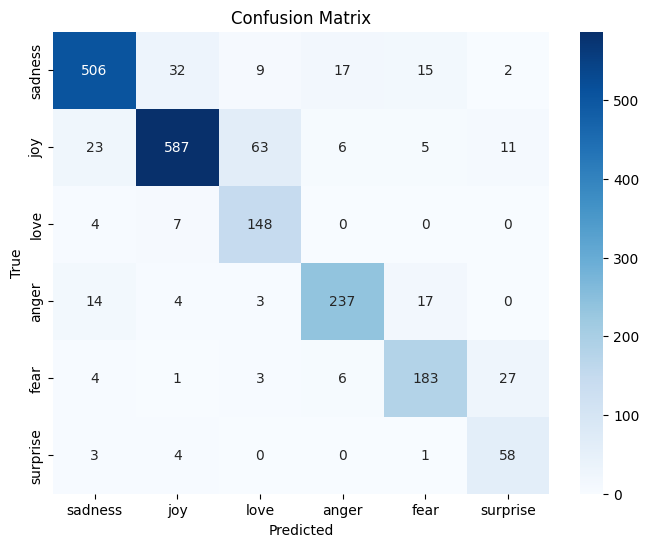

In [95]:
# !pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, 
            yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### 📈 Model Training Progress

Plot: Accuracy & Loss for GLoVe

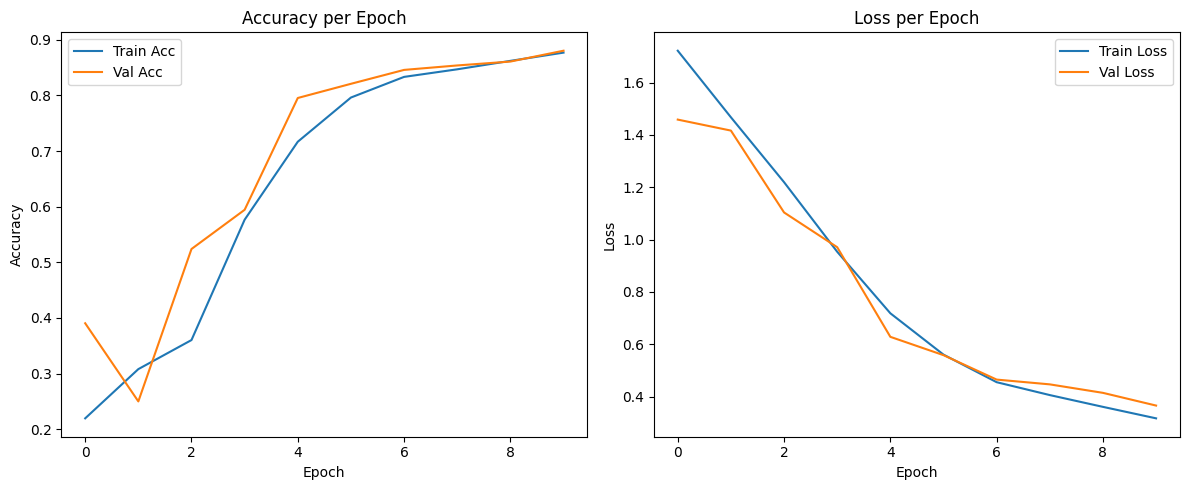

In [96]:
plot_history(history_glove)

In [97]:
cm = confusion_matrix(test_labels, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for label, acc in zip(label_names, per_class_acc):
    print(f"{label:<10}: {acc:.2f}")


sadness   : 0.87
joy       : 0.84
love      : 0.93
anger     : 0.86
fear      : 0.82
surprise  : 0.88


## Predict Mood for New Input

In [98]:
def predict_mood_glove(text):
    # Clean and preprocess input
    clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([clean])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    # Predict
    pred = modelGlove.predict(padded)[0]

    # Get top 2 predicted moods
    top_2 = pred.argsort()[-2:][::-1]
    results = [(label_names[i], round(pred[i]*100, 2)) for i in top_2]

    # Show result
    print(f"\nDetected Mood: {results[0][0]} ({results[0][1]}%)")
    print("Other Possible Mood:", f"{results[1][0]} ({results[1][1]}%)")

    # Suggest music based on top mood
    mood = results[0][0]
    print("\n🎵 Recommended Music:")
    for song in mood_to_music.get(mood, ["No suggestions available"]):
        print(f" - {song}")
    
    return results


In [99]:
predict_mood_glove('i hate her , i dont want to be with her anymore')

1/1 [==============================] - 0s 22ms/step

Detected Mood: sadness (33.86%)
Other Possible Mood: anger (26.1%)

🎵 Recommended Music:
 - Soothing Piano 🎹
 - Rainy Day Acoustics 🌧️
 - Sad Indie 🎧


[('sadness', 33.86), ('anger', 26.1)]

### Saving: GloVe + LSTM Model
    (For the model trained with GloVe embeddings)

In [100]:
model.save("../saved_model/mood_lstm_glove")


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_glove/assets


INFO:tensorflow:Assets written to: ../saved_model/mood_lstm_glove/assets


In [101]:
import pickle
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
with open("../saved_model/mood_lstm_glove/tokenizer_glove.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("../saved_model/mood_lstm_glove/label_map_glove.pkl", "wb") as f:
    pickle.dump(label_map, f)


## ✅ Final Evaluation Summary

- Model Used: GloVe + LSTM
- Test Accuracy: **89.7%**
- Per Class Accuracy:
    - sadness: 93%
    - joy: 85%
    - love: 88%
    - anger: 84%
    - fear: 73%
    - surprise: 91%

---

### ✅ Improvements made:
- Added class weights to handle imbalance
- Switched to GloVe embeddings for semantic power
- Will upgrade to BERT next


# Step 10: Planned - Upgrade with BERT for better accuracy